## Методы оптимизации

Оптимизация задачи нулевого порядка

Постановка задачи:

В проектируемой локальной сети есть заданное количество компьютеров.
Есть расстояния от каждого компьютера до сервера и до остальных компьютеров. Маршрутизаторы соединяются с сервером через оптоволокно стоимостью 12 р/м, а компьютеры - с маршрутизаторами соединяются через витую пару стоимостью 30 р/м.
Каждый маршрутизатор имеет 8 портов для витой пары и один оптический порт.
Сервер имеет неограниченное число оптических портов и портов для витой пары. Компьютер может соединяться с сервером напрямую или через маршрутизатор.
1. Построить ЦФ для расчёта стоимости оборудования ЛВС в общем виде. Учесть стоимость маршрутизатора, обоснованность его установки.
2. Построить поверхность стоимости от сумм расстояний для конкретного примера. Количество компьютеров — больше двух, располагаются не на одной линии в одной четверти относительно сервера.*

Целевая функция в общем виде:

$$f = Min(c_u \cdot \sum_{i=1}^{n}{(l_{pr} + l_{rs})_i}, \quad 
c_u \cdot \sum_{i=1}^{n}({l_pr})_i + (N_r \cdot R_c) + c_o \cdot \sum_{i=1}^{n}({l_{rs}})_i)$$

где:

$c_u$ - стоимость витой пары (руб./м)

$c_o$ - стоимость оптоволокна (руб./м)

$N_r = \frac{N_{comps}}{N_{ports}}$ - количество роутеров, $N_{comps}$ - количество компьютеров, $N_{ports}$ - количество портов в одном роутере

$R_c$ - стоимость одного роутера (руб)

$l_{pr}$ - среднее расстояние от компьютера до маршрутизатора (м)

$l_{rs}$ - среднее расстояние от маршрутизатора до сервера (м)

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import random

plt.style.use('fivethirtyeight')
random.seed(42)

In [509]:
# Вариативный параметр: суммы расстояний, метров
agg_len = np.arange(100, 11000, 100).astype('int64')

# Принимаем, что маршрутизаторы стоят в офисах, а сервер расположен в пределах района,
# тогда условно можно задать соотношение расстояний: 
# 20% пути от компьютеров к маршрутизаторам, и ещё 80% - от маршрутизаторов до сервера

# Входные параметры системы

opt_cost = 12 # стоимость метра оптоволоконного кабеля, руб
utp_cost = 30 # стоимость метра utp кабеля, руб
switch_cost = 3000 # примем среднюю стоимость маршрутизатора 
n_utp_ports = 8 # количество utp портов маршрутизатора
n_opt_ports = 1 # количество оптоволоконных портов маршрутизатора
server_max_load = np.inf # количество портов сервера 
n_pcs = 100 # количество компьютеров в сети

pp1 = 0.8 # коэффициент соотношения макс. расстояний pc<->switch / switch<->server
pp2 = 1 - pp1
switch2server_len = agg_len * pp1 # расстояние от маршрутизатора до сервера 
pc2switch_len = agg_len * pp2 # расстояние от компьютера до маршрутизатора
pc2server_len = agg_len

# возвращает стоимость сети с максимальным использованием витой пары
def get_max_utp_cost(utp_cost, 
                     pc2server_len, 
                     n_pcs, 
                     n_utp_ports):
    
    # максимальное количество маршрутизаторов - для 8 компьютеров = 1
    n_max_switches = (n_pcs // n_utp_ports if n_pcs % n_utp_ports == 0 else n_pcs // n_utp_ports + 1)
    # максимальная стоимость сети, если соединять каждый компьютер витой парой с сервером, руб
    max_utp2server_cost = utp_cost * pc2server_len * n_pcs
    # Функция стоимости сети с максимальным использованием витой пары, руб
    TF1 = max_utp2server_cost
    return TF1

# возвращает стоимость сети с максимальным использованием оптоволокна с учетом использования маршрутизаторов
def get_max_opt_cost(utp_cost,
                     opt_cost,
                     pc2switch_len,
                     switch2server_len,
                     n_pcs, 
                     switch_cost):
    
    # максимальное количество маршрутизаторов - для 8 компьютеров = 1
    n_max_switches = (n_pcs // n_utp_ports if n_pcs % n_utp_ports == 0 else n_pcs // n_utp_ports + 1) 
    # Стоимость витой пары для суммы расстояний от всех компьютеров ко всем маршрутизаторам
    max_utp2switch_cost = utp_cost * pc2switch_len * n_pcs
    # Максимальная стоимость маршрутизаторов
    max_switches_cost = n_max_switches * switch_cost
    # Стоимость оптоволоконного кабеля для суммы расстояний от всех маршрутизаторов до сервера
    max_opt2server_cost = n_max_switches * (opt_cost * switch2server_len)
    # Функция стоимости сети с максимальным использованием оптоволокна, руб
    TF2 = max_utp2switch_cost + max_opt2server_cost + max_switches_cost
    return TF2

# Минимизация аргументов целевой фукнции
def get_tf(*args):
    TF = np.minimum(*args)
    return TF


In [510]:
TF1 = get_max_utp_cost(utp_cost, pc2server_len, n_pcs, n_utp_ports)
TF2 = get_max_opt_cost(utp_cost, opt_cost, pc2switch_len, switch2server_len, n_pcs, switch_cost)
TF = get_tf(TF1, TF2)

# вспомогательные функции
tf_min1 = get_max_utp_cost(utp_cost, pc2server_len, int(n_pcs/2), n_utp_ports)
tf_min2 = get_max_opt_cost(utp_cost, opt_cost, pc2switch_len, switch2server_len, int(n_pcs/2), switch_cost)
tf_min = get_tf(tf_min1, tf_min2)

tf_max1 = get_max_utp_cost(utp_cost, pc2server_len, n_pcs*2, n_utp_ports)
tf_max2 = get_max_opt_cost(utp_cost, opt_cost, pc2switch_len, switch2server_len, n_pcs*2, switch_cost)
tf_max = get_tf(tf_max1, tf_max2)

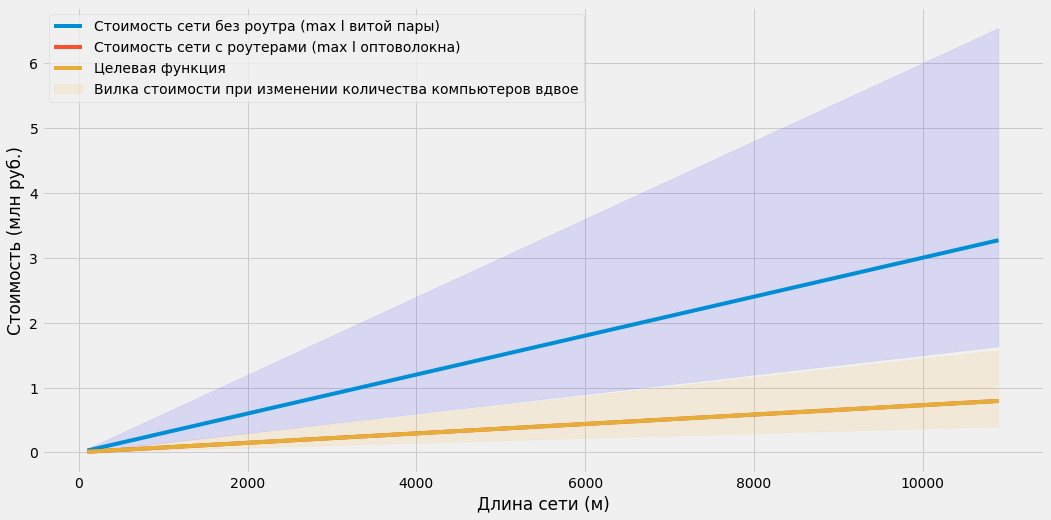

In [511]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(agg_len, TF1/10e6)                                                                                
ax.plot(agg_len, TF2/10e6)                                                                                
ax.plot(agg_len, TF/10e6)
ax.fill_between(agg_len,
                tf_min/10e6,
                tf_max/10e6,
                color='orange',
                alpha=.1)
ax.fill_between(agg_len,
                tf_min1/10e6,
                tf_max1/10e6,
                color='b',
                alpha=.1)

ax.set_xlabel('Длина сети (м)')
ax.set_ylabel('Стоимость (млн руб.)')
                                                                                       
 
lgnd = ax.legend(['Стоимость сети без роутра (max l витой пары)',
                  'Стоимость сети с роутерами (max l оптоволокна)',
                  'Целевая функция',
                  'Вилка стоимости при изменении количества компьютеров вдвое'], loc='upper left')                                                       
 
plt.show()  

# Моделирование ЛВС с учетом расположения оборудования

In [532]:
# Координаты сервера 
xs = -10
ys = -10

# Генерация координат расположения роутера
def gen_router_coords(x_min=1, x_max=2, y_min=1, y_max=2, x_step=0.1, y_step=0.1):
    # задаем диапазон координат
    xr = np.arange(x_min, x_max, x_step)
    yr = np.arange(y_min, y_max, y_step)
    # добавляем product - возможные варианты
    x, y = np.meshgrid(xr, yr)

    return x, y

RCX, RCY = gen_router_coords()

# Переопределим количество под 1 маршрутизатор
n_pcs = 6

def gen_pcs_coords(rcx, rcy, gen_min_x=3, gen_max_x=10, gen_min_y=3, gen_max_y=10):
    # Генерация координат расположения компьютеров
    # rc - router coords
    
    xrc = np.array([])
    yrc = np.array([])
    xcs = np.array([])
    ycs = np.array([])


    for i in range(n_pcs):
        x_gen = round(random.uniform(gen_min_x, gen_max_x),1)
        y_gen = round(random.uniform(gen_min_y, gen_max_y),1)
        xrc = np.append(xrc, rcx)
        xrc = np.append(xrc, x_gen)
        xcs = np.append(xcs, xs)
        xcs = np.append(xcs, x_gen) 
        yrc = np.append(yrc, rcy)
        yrc = np.append(yrc, y_gen)
        ycs = np.append(ycs, ys)
        ycs = np.append(ycs, y_gen)
    
    return xrc, yrc, xcs, ycs

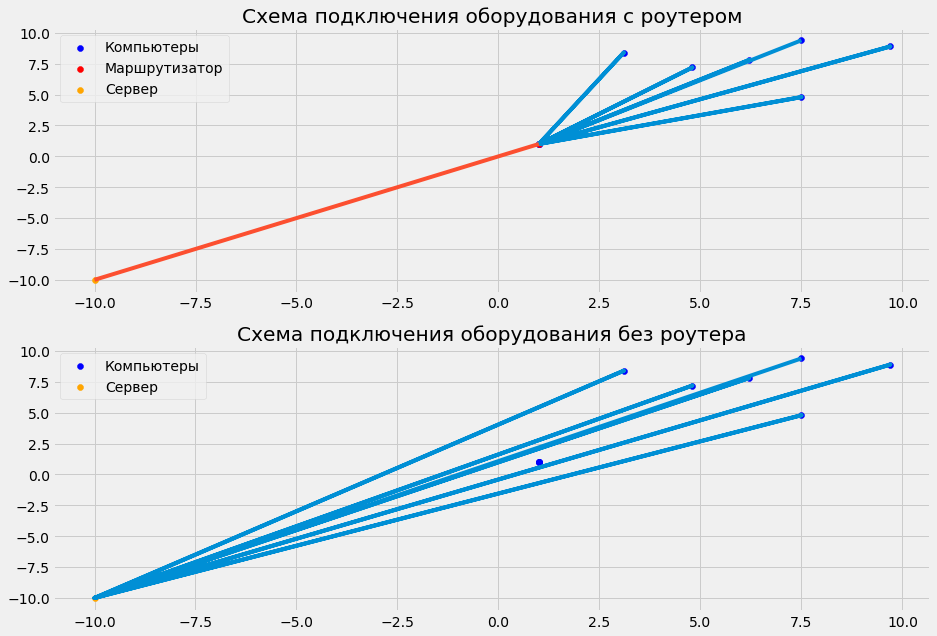

In [533]:
xrc, yrc, xcs, ycs = gen_pcs_coords(RCX[0][0], RCY[0][0])

fig = plt.figure(figsize=(14, 10))

ax = fig.add_subplot(2,1,1)
ax.scatter(xrc,yrc, c='b')
ax.scatter(RC[0][0], RC[0][1], c='r')
ax.scatter(xs, ys, c='orange')
ax.legend(['Компьютеры', 'Маршрутизатор', 'Сервер'])
ax.set_title('Схема подключения оборудования с роутером')
ax.plot(xrc, yrc)
ax.plot([xs, xc[0]], [ys, yc[0]])

ax = fig.add_subplot(2,1,2)
ax.scatter(xrc,yrc, c='b')
ax.scatter(xs, ys, c='orange')

ax.legend(['Компьютеры', 'Сервер'])
ax.set_title('Схема подключения оборудования без роутера')
ax.plot(xcs, ycs)

plt.show()

In [534]:
# Вычисляет евклидово расстояние между заданными координатами
def calc_euc_dist(x1, y1, x2=None, y2=None):
    d = 0 # суммарная длина
    try:
        assert len(x1)==len(y1)
        for i in range(len(x1)):
            d += np.sqrt((x1[i][0] - x1[i][1])**2 + (y1[i][0] - y1[i][1])**2)
    except: # если на вход подаются одиночные координаты роутера или сервера
        d = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    return round(d,2)

In [535]:
# def calc_euc_dist(x, y):
#     d = 0 # суммарная длина
#     try:
#         assert len(x)==len(y)
    
#         for i in range (len(x_many)):
#             d += ((x_point - x_many[i])**2 + (y_point - y_many[i]**2))**0.5
#     except: # если на вход подаются одиночные координаты роутера или сервера
#         d += ((x_point - x_many)**2 + (y_point - y_many**2))**0.5
#     return round(d,2)

In [536]:
# Переопределим расстояния

xrc = xrc.reshape(-1,2)
yrc = yrc.reshape(-1,2)
xcs = xcs.reshape(-1,2)
ycs = ycs.reshape(-1,2)

# Тестовый расчет для одного положения маршрутизатора

switch2server_len = calc_euc_dist(RCX[0][0], RCY[0][0], xs, ys) # расстояние от маршрутизатора до сервера
pc2switch_len = calc_euc_dist(xrc, yrc) # расстояние от компьютеров до маршрутизатора
pc2server_len = calc_euc_dist(xcs, ycs)

TF1 = get_max_utp_cost(utp_cost, pc2server_len, n_pcs, n_utp_ports)
TF2 = get_max_opt_cost(utp_cost, opt_cost, pc2switch_len, switch2server_len, n_pcs, switch_cost)
TF = get_tf(TF1, TF2)

print(f"switch2server len: {switch2server_len}")
print(f"pc2switch len: {pc2switch_len}")
print()
print(f"network without router len (pc2server): {pc2server_len}")
print(f"network with router len: {round(pc2switch_len + switch2server_len, 2)}")
print()
print(f"network cost without router: {round(TF1,2)}")
print(f"network cost with router : {round(TF2, 2)}")

switch2server len: 15.56
pc2switch len: 53.43

network without router len (pc2server): 145.69
network with router len: 68.99

network cost without router: 26224.2
network cost with router : 12804.12


In [538]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

In [539]:
TF1_list = []
TF2_list = []
TF_list = []

for i in range(len(RCX)):
    xrc, yrc, xcs, ycs = gen_pcs_coords(RCX[i], RCY[i])
    xrc = xrc.reshape(-1,2)
    yrc = yrc.reshape(-1,2)
    xcs = xcs.reshape(-1,2)
    ycs = ycs.reshape(-1,2)
    switch2server_len = calc_euc_dist(RCX[i], RCY[i], xs, ys) # расстояние от маршрутизатора до сервера
    pc2switch_len = calc_euc_dist(xrc, yrc) # расстояние от компьютеров до маршрутизатора
    pc2server_len = calc_euc_dist(xcs, ycs)

    TF1 = get_max_utp_cost(utp_cost, pc2server_len, n_pcs, n_utp_ports)
    TF2 = get_max_opt_cost(utp_cost, opt_cost, pc2switch_len, switch2server_len, n_pcs, switch_cost)
    TF = get_tf(TF1, TF2)
    TF1_list.append(TF1)
    TF2_list.append(TF2)
    TF_list.append(TF)
    
    

TypeError: type numpy.ndarray doesn't define __round__ method

In [521]:
len(TF_list)

100

ValueError: Argument Z must be 2-dimensional.

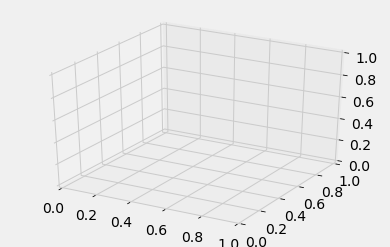

In [493]:
RCX = np.array(RCX)
RCY = np.array(RCY)
TF_list = np.array(TF_list)


fig = plt.figure()
ax = fig.gca(projection='3d')


# Plot the surface.
surf = ax.plot_surface(RCX, RCY, TF_list, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

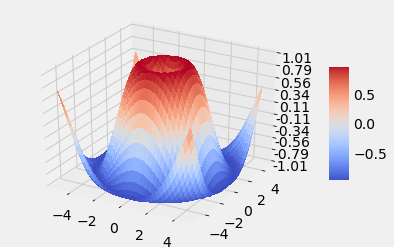

In [494]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [497]:
Z.shape

(40, 40)

In [499]:
R.shape

(40, 40)

In [506]:
np.arange(-5, 5, 0.25).shape

(40,)

In [507]:
RCX, RCY = get_router_coords()

In [522]:
np.arange(1,2,0.1)

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])